In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import axis3d
from IPython.display import FileLink

plt.rcParams['figure.figsize'] = (16, 12)

In [2]:
df = pd.read_csv('ready_dataframe.csv', parse_dates=['transaction_date', 'all_dates'])

In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246740 entries, 0 to 246739
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   transaction_date     246740 non-null  datetime64[ns]
 1   store_number         246740 non-null  float64       
 2   loyalty_card_number  246740 non-null  int64         
 3   tax_ID               246740 non-null  float64       
 4   product_number       246740 non-null  float64       
 5   product_name         246740 non-null  object        
 6   product_quantity     246740 non-null  float64       
 7   total_sales          246740 non-null  float64       
 8   weights_of_chips     246740 non-null  int64         
 9   company_name         246740 non-null  object        
 10  lifestage            246740 non-null  object        
 11  premium_customer     246740 non-null  object        
 12  day_of_week          246740 non-null  object        
 13  all_dates     

In [5]:
df['year'] = df.all_dates.dt.year

In [6]:
df['month'] = df.all_dates.dt.month

In [7]:
df.month = df.month.astype('str')

# Let's filter to the pre-trial period and stores with full observation periods.

In [8]:
stores_full_observations = avg_price_per_unit = df.groupby(['store_number'])\
                        .agg({'month': 'nunique'})
stores_full_observations.head()

,month
store_number,
1.0,12
2.0,12
3.0,12
4.0,12
5.0,12


In [9]:
stores_full_observations.month.unique()

array([12,  2, 11,  1, 10,  3])

In [10]:
stores_with_full_period = stores_full_observations.query('month == 12')

In [11]:
stores_with_full_period.month.unique()

array([12])

In [12]:
numbers_of_stores = stores_with_full_period.index

In [13]:
df_valid_period = df.query('store_number in @numbers_of_stores and all_dates<"2019-02-01"')

Checking our culculations

In [14]:
set(numbers_of_stores).difference(set(df_valid_period.store_number.unique()))

set()

In [15]:
df_valid_period

,transaction_date,store_number,loyalty_card_number,tax_ID,product_number,product_name,product_quantity,total_sales,weights_of_chips,company_name,lifestage,premium_customer,day_of_week,all_dates,year,month
0,2018-10-17,1.0,1000,1.0,5.0,Natural Chip Compny SeaSalt,2.0,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium,Wednesday,2018-07-01,2018,7
1,2019-05-14,1.0,1307,348.0,66.0,CCs Nacho Cheese,3.0,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget,Tuesday,2018-07-02,2018,7
2,2018-11-10,1.0,1307,346.0,96.0,WW Oriinal Stacked Chips,2.0,3.8,160,WOOLWORTHS,MIDAGE SINGLES/COUPLES,Budget,Saturday,2018-07-03,2018,7
3,2019-03-09,1.0,1307,347.0,54.0,CCs Oriinal,1.0,2.1,175,CCs,MIDAGE SINGLES/COUPLES,Budget,Saturday,2018-07-04,2018,7
4,2019-05-20,1.0,1343,383.0,61.0,Smiths Crinkle Cut Chips Chicken,2.0,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,Monday,2018-07-05,2018,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246734,2018-11-12,272.0,272319,270087.0,44.0,Thins Chips Liht Tany,2.0,6.6,175,Thins,YOUNG SINGLES/COUPLES,Premium,Monday,2018-11-12,2018,11
246736,2018-08-13,272.0,272358,270154.0,74.0,Tostitos Splash Of Lime,1.0,4.4,175,Tostitos,YOUNG SINGLES/COUPLES,Premium,Monday,2018-08-13,2018,8
246737,2018-11-06,272.0,272379,270187.0,51.0,Doritos Mexicana,2.0,8.8,170,Doritos,YOUNG SINGLES/COUPLES,Premium,Tuesday,2018-11-06,2018,11
246738,2018-12-27,272.0,272379,270188.0,42.0,Doritos Corn Chip Mexican Jalapeno,2.0,7.8,150,Doritos,YOUNG SINGLES/COUPLES,Premium,Thursday,2018-12-27,2018,12


Select control stores
The client has selected store numbers 77, 86 and 88 as trial stores and want
control stores to be established stores that are operational for the entire
observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer
Let's first create the metrics of interest and filter to stores that are present
throughout the pre-trial period.
Calculate these measures over time for each store. 

## For each store and month we will calculate total sales.

In [16]:
total_sales = df_valid_period.groupby(['store_number', 'year', 'month'], as_index=False).agg({'total_sales': 'sum'})
total_sales

,store_number,year,month,total_sales
0,1.0,2018,10,169.40
1,1.0,2018,11,181.00
2,1.0,2018,12,160.60
3,1.0,2018,7,210.00
4,1.0,2018,8,168.40
...,...,...,...,...
1808,272.0,2018,12,363.10
1809,272.0,2018,7,392.30
1810,272.0,2018,8,326.95
1811,272.0,2018,9,294.50



## For each store and month we will calculate number of customers.

In [17]:
number_of_customers = df_valid_period.groupby(['store_number', 'year', 'month'], as_index=False)\
                        .agg({'loyalty_card_number': 'nunique'})
number_of_customers

,store_number,year,month,loyalty_card_number
0,1.0,2018,10,38
1,1.0,2018,11,43
2,1.0,2018,12,37
3,1.0,2018,7,50
4,1.0,2018,8,41
...,...,...,...,...
1808,272.0,2018,12,43
1809,272.0,2018,7,47
1810,272.0,2018,8,39
1811,272.0,2018,9,31


## For each store and month we will calculate transactions per customer.

In [18]:
transactions_per_customer = df_valid_period.groupby(['store_number', 'year', 'month'], as_index=False)\
                        .agg({'loyalty_card_number': 'count'})

transactions_per_customer.rename(columns = {'loyalty_card_number': 'loyalty_card_number_count'},  inplace=True)
transactions_per_customer['per_customer'] = transactions_per_customer.loyalty_card_number_count/number_of_customers.loyalty_card_number

transactions_per_customer

,store_number,year,month,loyalty_card_number_count,per_customer
0,1.0,2018,10,39,1.026316
1,1.0,2018,11,44,1.023256
2,1.0,2018,12,40,1.081081
3,1.0,2018,7,54,1.080000
4,1.0,2018,8,41,1.000000
...,...,...,...,...,...
1808,272.0,2018,12,43,1.000000
1809,272.0,2018,7,48,1.021277
1810,272.0,2018,8,43,1.102564
1811,272.0,2018,9,35,1.129032


## For each store and month we will calculate chips per customer.

In [19]:
chips_per_customer = df_valid_period.groupby(['store_number', 'year', 'month'], as_index=False)\
                        .agg({'product_quantity': 'mean'})
chips_per_customer

,store_number,year,month,product_quantity
0,1.0,2018,10,1.256410
1,1.0,2018,11,1.204545
2,1.0,2018,12,1.200000
3,1.0,2018,7,1.259259
4,1.0,2018,8,1.268293
...,...,...,...,...
1808,272.0,2018,12,1.883721
1809,272.0,2018,7,1.875000
1810,272.0,2018,8,1.767442
1811,272.0,2018,9,1.971429


## For each store and month we will calculate average price per unit.

In [20]:
avg_price_per_unit = df_valid_period.groupby(['store_number', 'year', 'month'], as_index=False)\
                        .agg({'product_quantity': 'sum', 'total_sales': 'sum'})
avg_price_per_unit['avg_price'] = avg_price_per_unit.total_sales/avg_price_per_unit.product_quantity
avg_price_per_unit

,store_number,year,month,product_quantity,total_sales,avg_price
0,1.0,2018,10,49.0,169.40,3.457143
1,1.0,2018,11,53.0,181.00,3.415094
2,1.0,2018,12,48.0,160.60,3.345833
3,1.0,2018,7,68.0,210.00,3.088235
4,1.0,2018,8,52.0,168.40,3.238462
...,...,...,...,...,...,...
1808,272.0,2018,12,81.0,363.10,4.482716
1809,272.0,2018,7,90.0,392.30,4.358889
1810,272.0,2018,8,76.0,326.95,4.301974
1811,272.0,2018,9,69.0,294.50,4.268116


# Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.

## Total sales correlation

In [21]:
total_sales

,store_number,year,month,total_sales
0,1.0,2018,10,169.40
1,1.0,2018,11,181.00
2,1.0,2018,12,160.60
3,1.0,2018,7,210.00
4,1.0,2018,8,168.40
...,...,...,...,...
1808,272.0,2018,12,363.10
1809,272.0,2018,7,392.30
1810,272.0,2018,8,326.95
1811,272.0,2018,9,294.50


In [22]:
list_of_store_numbers = total_sales.store_number.unique()
list_of_store_numbers

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  45.,  46.,  47.,
        48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
        59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
        70.,  71.,  72.,  73.,  74.,  75.,  77.,  78.,  79.,  80.,  81.,
        82.,  83.,  84.,  86.,  87.,  88.,  89.,  90.,  91.,  93.,  94.,
        95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116.,
       118., 119., 120., 121., 122., 123., 124., 125., 126., 127., 128.,
       129., 130., 131., 132., 133., 134., 135., 136., 137., 138., 139.,
       140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150.,
       151., 152., 153., 154., 155., 156., 157., 15

## Correlation function

In [23]:
from scipy import stats

In [24]:
def correlation(list_of_store_numbers, df, store_number, col):      
    value = dict()
    for j in list_of_store_numbers: 
        res = stats.pearsonr(df.query('store_number == @store_number')[col].values,\
                             df.query('store_number == @j')[col].values)
        value[j] = [res.statistic, res.pvalue]
    return value

In [25]:
# value = dict()
# for j in list_of_store_numbers: 
#     res = total_sales.query('store_number == 77').\
#     merge(total_sales.query('store_number == @j'), on='month')[['total_sales_x', 'total_sales_y']].corr()
#     if len(res.query('total_sales_x != 1').total_sales_x) > 0:
#         temp = res.query('total_sales_x != 1').total_sales_x.item()
#         value[j] = temp



In [26]:
cor_store_77 = correlation(list_of_store_numbers, df=total_sales,  store_number=77, col='total_sales')

In [27]:
cor_store_86 = correlation(list_of_store_numbers, df=total_sales,  store_number=86, col='total_sales')

In [28]:
cor_store_88 = correlation(list_of_store_numbers, df=total_sales,  store_number=88, col='total_sales')

## Number of customers correlation

In [29]:
number_of_customers

,store_number,year,month,loyalty_card_number
0,1.0,2018,10,38
1,1.0,2018,11,43
2,1.0,2018,12,37
3,1.0,2018,7,50
4,1.0,2018,8,41
...,...,...,...,...
1808,272.0,2018,12,43
1809,272.0,2018,7,47
1810,272.0,2018,8,39
1811,272.0,2018,9,31


In [30]:
cor_store_numb_77 = correlation(list_of_store_numbers, df=number_of_customers,  store_number=77, col='loyalty_card_number')

In [31]:
cor_store_numb_86 = correlation(list_of_store_numbers, df=number_of_customers,  store_number=86, col='loyalty_card_number')

In [32]:
cor_store_numb_88 = correlation(list_of_store_numbers, df=number_of_customers,  store_number=88, col='loyalty_card_number')

## Transactions per customer correlation.

In [33]:
transactions_per_customer

,store_number,year,month,loyalty_card_number_count,per_customer
0,1.0,2018,10,39,1.026316
1,1.0,2018,11,44,1.023256
2,1.0,2018,12,40,1.081081
3,1.0,2018,7,54,1.080000
4,1.0,2018,8,41,1.000000
...,...,...,...,...,...
1808,272.0,2018,12,43,1.000000
1809,272.0,2018,7,48,1.021277
1810,272.0,2018,8,43,1.102564
1811,272.0,2018,9,35,1.129032


In [34]:
cor_store_trans_77 = correlation(list_of_store_numbers, df=transactions_per_customer,  store_number=77, col='per_customer')

/home/alberdinamariya/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [35]:
cor_store_trans_86 = correlation(list_of_store_numbers, df=transactions_per_customer,  store_number=86, col='per_customer')

In [36]:
cor_store_trans_88 = correlation(list_of_store_numbers, df=transactions_per_customer,  store_number=88, col='per_customer')

## Chips per customer correlation

In [37]:
chips_per_customer

,store_number,year,month,product_quantity
0,1.0,2018,10,1.256410
1,1.0,2018,11,1.204545
2,1.0,2018,12,1.200000
3,1.0,2018,7,1.259259
4,1.0,2018,8,1.268293
...,...,...,...,...
1808,272.0,2018,12,1.883721
1809,272.0,2018,7,1.875000
1810,272.0,2018,8,1.767442
1811,272.0,2018,9,1.971429


In [38]:
cor_store_chips_77 = correlation(list_of_store_numbers, df=chips_per_customer,  store_number=77, col='product_quantity')

In [39]:
cor_store_chips_86 = correlation(list_of_store_numbers, df=chips_per_customer,  store_number=86, col='product_quantity')

In [40]:
cor_store_chips_88 = correlation(list_of_store_numbers, df=chips_per_customer,  store_number=88, col='product_quantity')

## Average price per unit correlation.

In [41]:
avg_price_per_unit

,store_number,year,month,product_quantity,total_sales,avg_price
0,1.0,2018,10,49.0,169.40,3.457143
1,1.0,2018,11,53.0,181.00,3.415094
2,1.0,2018,12,48.0,160.60,3.345833
3,1.0,2018,7,68.0,210.00,3.088235
4,1.0,2018,8,52.0,168.40,3.238462
...,...,...,...,...,...,...
1808,272.0,2018,12,81.0,363.10,4.482716
1809,272.0,2018,7,90.0,392.30,4.358889
1810,272.0,2018,8,76.0,326.95,4.301974
1811,272.0,2018,9,69.0,294.50,4.268116


In [42]:
cor_store_avg_77 = correlation(list_of_store_numbers, df=avg_price_per_unit,  store_number=77, col='avg_price')

In [43]:
cor_store_avg_86 = correlation(list_of_store_numbers, df=avg_price_per_unit,  store_number=86, col='avg_price')

In [44]:
cor_store_avg_88 = correlation(list_of_store_numbers, df=avg_price_per_unit,  store_number=88, col='avg_price')

## we may chose p_value<0,05 and correlation more than 0,7 to choose suitable stores.

In [45]:
def table_correlation(corr_metrics, p_value, correlation):
    res = dict()
    for key,value in corr_metrics.items():
        if (value[0] >= correlation or value[0] <= -correlation) and value[1] < p_value:
            res[key] = [value[0], value[1]]
    return res         

In [46]:
stores_sales_77 = table_correlation(corr_metrics=cor_store_77, p_value=0.05, correlation=0.7)

In [47]:
stores_numb_77 = table_correlation(corr_metrics=cor_store_numb_77, p_value=0.05, correlation=0.7)

In [48]:
similar_stores_to_77 = set(stores_sales_77.keys())& set(stores_numb_77.keys())
similar_stores_to_77

{9.0, 77.0, 157.0, 162.0, 186.0, 233.0}

In [49]:
stores_sales_86 = table_correlation(corr_metrics=cor_store_86, p_value=0.05, correlation=0.7)


In [50]:
stores_numb_86 = table_correlation(corr_metrics=cor_store_numb_86, p_value=0.05, correlation=0.7)

In [51]:
similar_stores_to_86 = set(stores_sales_86.keys())& set(stores_numb_86.keys())
similar_stores_to_86

{86.0, 155.0}

In [52]:
stores_sales_88 = table_correlation(corr_metrics=cor_store_88, p_value=0.05, correlation=0.7)

In [53]:
stores_numb_88 = table_correlation(corr_metrics=cor_store_numb_88, p_value=0.05, correlation=0.7)

In [54]:
similar_stores_to_88 = set(stores_sales_88.keys())& set(stores_numb_88.keys())

In [55]:
similar_stores_to_88

{88.0}

In [56]:
cor_store_88

{1.0: [0.6551983956289403, 0.11016760861274533],
 2.0: [-0.48781557578538753, 0.26676805075620336],
 3.0: [-0.5585077331888858, 0.192523736487302],
 4.0: [-0.5803015406475007, 0.17197105283568914],
 5.0: [0.213003258473512, 0.6465413976750768],
 6.0: [0.09903278661006223, 0.8326999394843351],
 7.0: [0.4006335723499198, 0.37310623453684877],
 8.0: [-0.6292483963150707, 0.1300072551178054],
 9.0: [0.42512103736596196, 0.3417003172448471],
 10.0: [0.1093156845633588, 0.8155267730561411],
 12.0: [-0.16443635392403974, 0.7246029095298316],
 13.0: [0.33436639943048596, 0.46355372716667526],
 14.0: [0.45427539431541547, 0.30584537402847806],
 15.0: [-0.42759891462555033, 0.3385869438328566],
 16.0: [0.029165246295417682, 0.9505085953620381],
 17.0: [-0.3995814156283062, 0.374481167286327],
 18.0: [-0.04626449160983194, 0.9215429874398975],
 19.0: [-0.12437677641094827, 0.7904808198498728],
 20.0: [-0.17106649976223043, 0.7138190368673862],
 21.0: [0.04328730230364738, 0.9265820233154166],
 22

In [57]:
stores_numb_88

{14.0: [0.9559752052403879, 0.000762740476892847],
 35.0: [0.7715692253424996, 0.042171059527333965],
 57.0: [0.7698186806082465, 0.04293994344305898],
 77.0: [0.8539667858464666, 0.014445509716088845],
 88.0: [0.9999999999999998, 1.411088991461081e-39],
 178.0: [0.9287152141473084, 0.0025070102233084274],
 208.0: [-0.7943228176446844, 0.03287069047607607],
 233.0: [0.7863939199352599, 0.03596592786225097],
 237.0: [0.9857550954123973, 4.616155537089377e-05],
 266.0: [-0.7940157920136566, 0.03298766299506544]}

## The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [58]:
for key,value in stores_sales_77.items():
    if key in similar_stores_to_77:
        print(key, stores_sales_77[key])

9.0 [-0.770266756106569, 0.04274240736139248]
77.0 [1.0, 0.0]
157.0 [0.7765451462605506, 0.04002731411945841]
162.0 [0.8575839389643507, 0.013595218588036553]
186.0 [-0.9171305971313111, 0.0036297903107149576]
233.0 [0.9736429414543201, 0.0002135680496620952]


In [59]:
final_stores_similar_to_77 = [233, 186, 50, 162, 71]

In [60]:
for key,value in stores_sales_86.items():
    if key in similar_stores_to_86:
        print(key, stores_sales_86[key])

86.0 [0.9999999999999999, 2.494476486799542e-40]
155.0 [0.869532475367053, 0.010994112545311251]


In [61]:
final_stores_similar_to_86 = [260, 155, 6, 138]

In [62]:
for key,value in stores_sales_88.items():
    if key in similar_stores_to_88:
        print(key, stores_sales_88[key])

88.0 [0.9999999999999999, 2.494476486799542e-40]


## Vizualisations

In [63]:
df_valid_period.groupby('store_number', as_index=False).\
agg({'total_sales': 'sum'}).query('store_number == 77 or store_number == 50 or store_number == 205 or store_number == 233')

,store_number,total_sales
46,50.0,1788.9
72,77.0,1595.5
195,205.0,1700.3
220,233.0,1534.5


## Total_sales boxplot

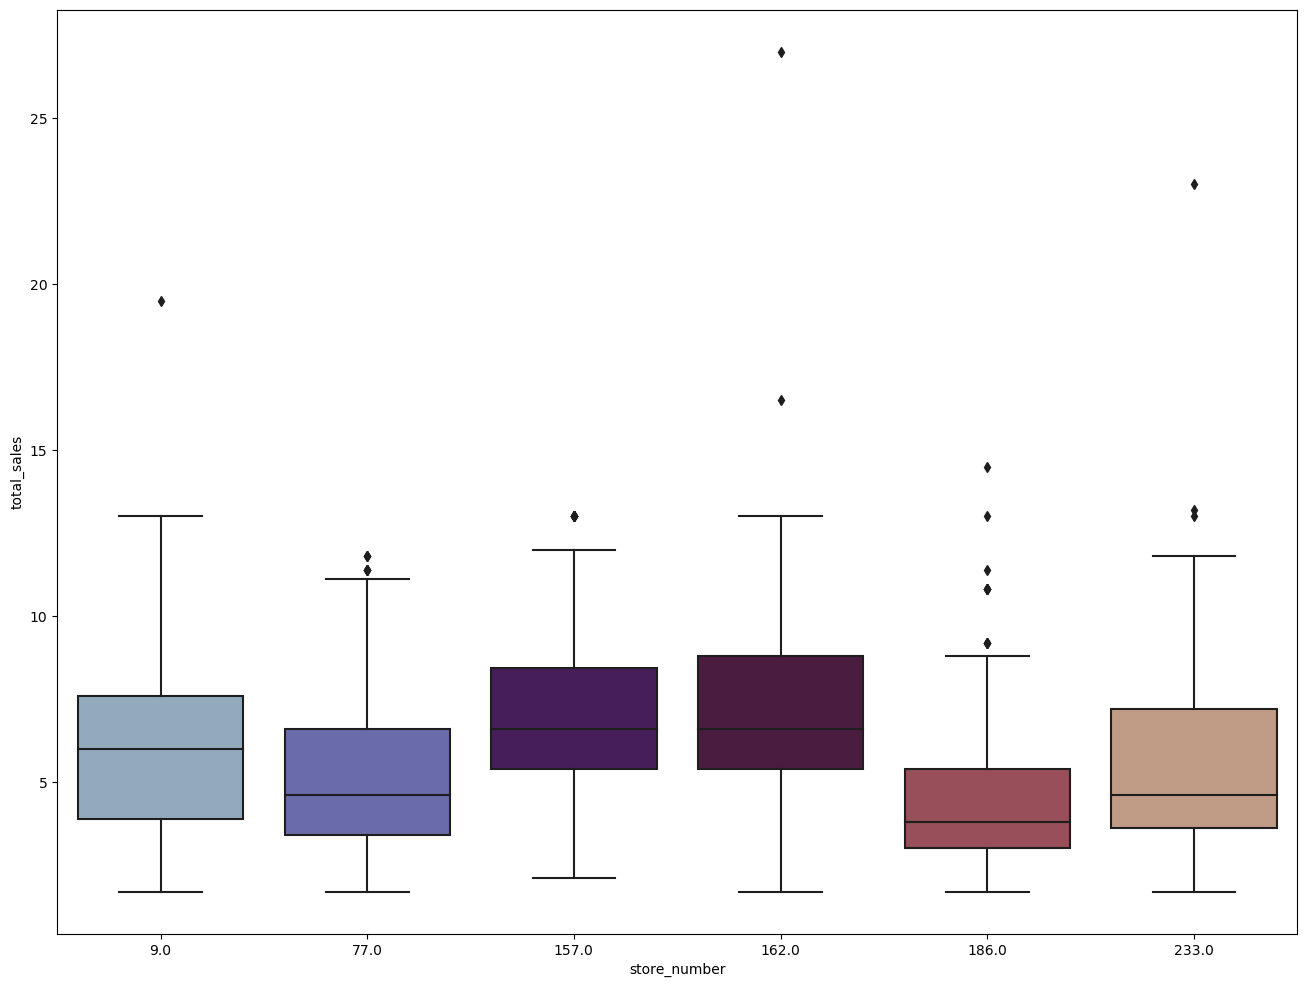

In [64]:
# 77 store
sns.boxplot(data = df_valid_period.\
        query('store_number == 77 or store_number == 9 or store_number == 162 or store_number == 157 or store_number == 233 or store_number == 186'),\
        x='store_number', y='total_sales', palette='twilight')


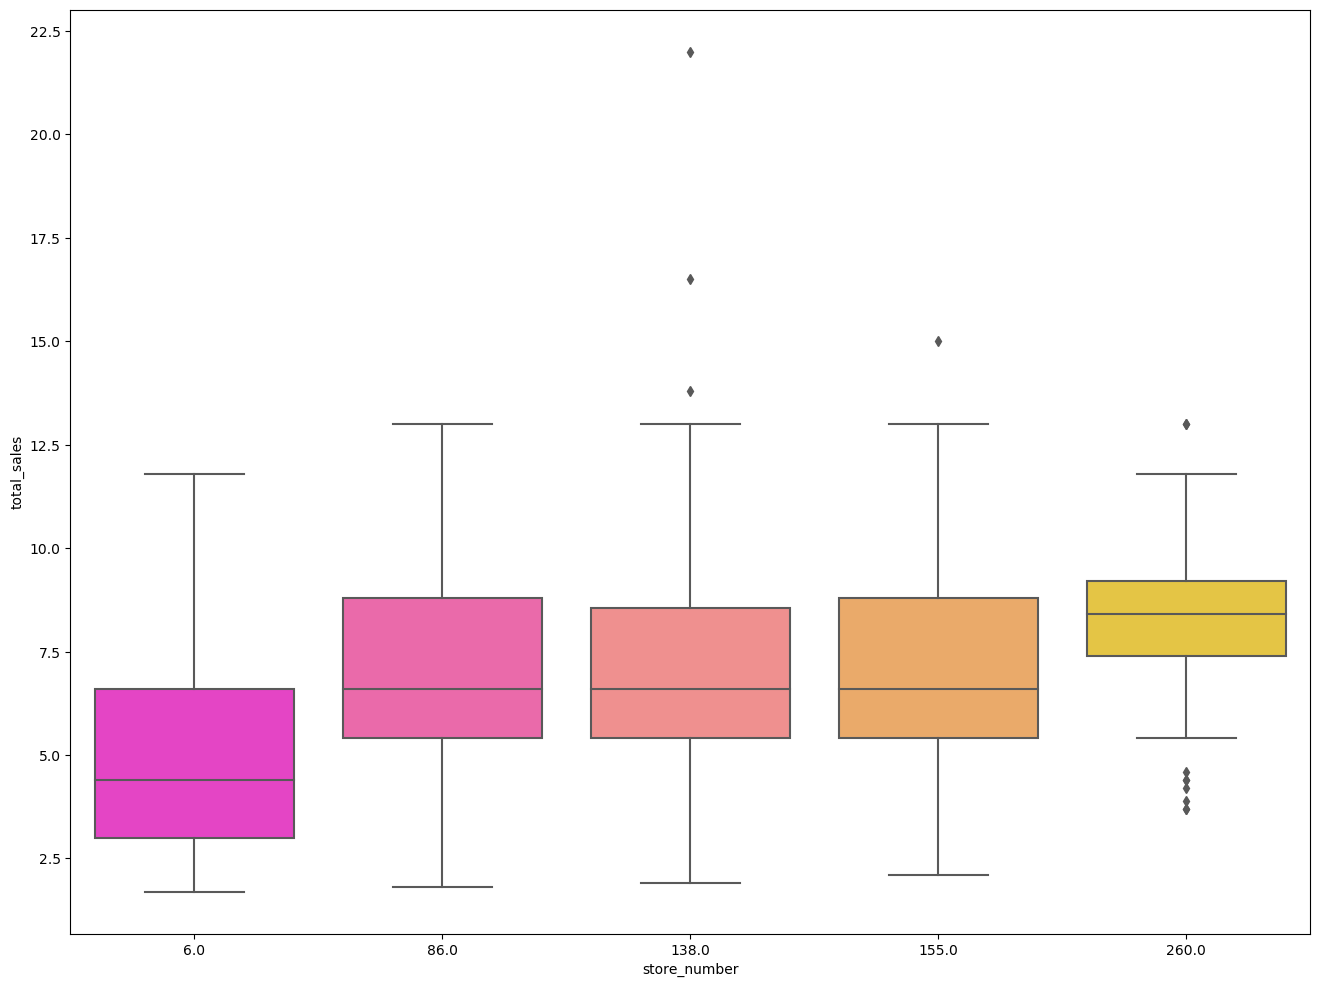

In [65]:
# 86 store
sns.boxplot(data = df_valid_period.\
        query('store_number == 86 or store_number == 6 \
        or store_number == 155 or store_number == 138 or store_number == 260'),\
        x='store_number', y='total_sales', palette='spring')

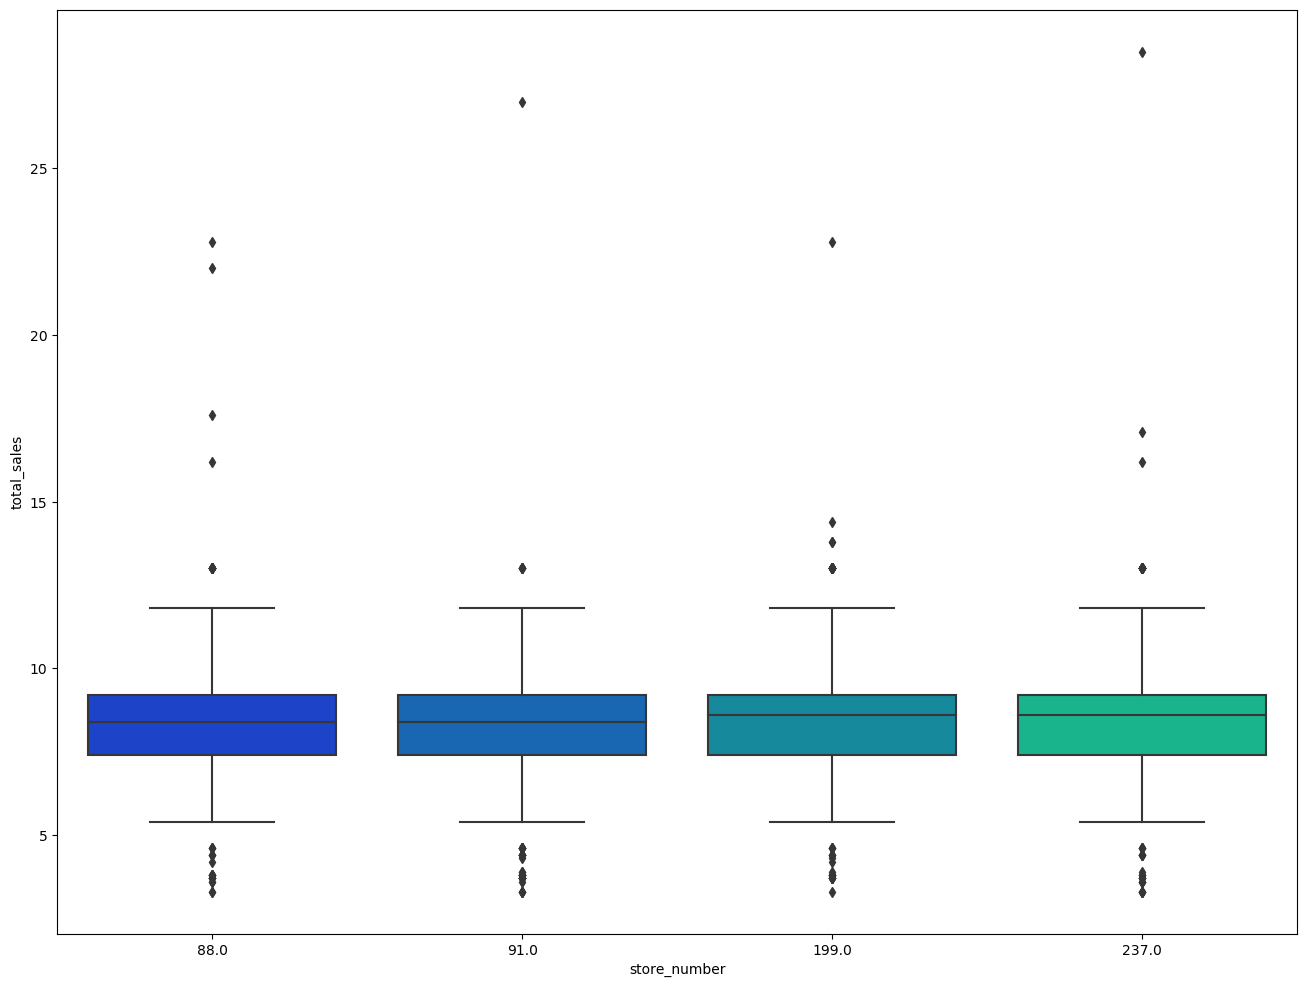

In [66]:
# 88
sns.boxplot(data = df_valid_period.\
        query('store_number == 88 or store_number == 91\
         or store_number == 237\
         or store_number == 199'),
        x='store_number', y='total_sales', palette='winter')

## Number of unique customers

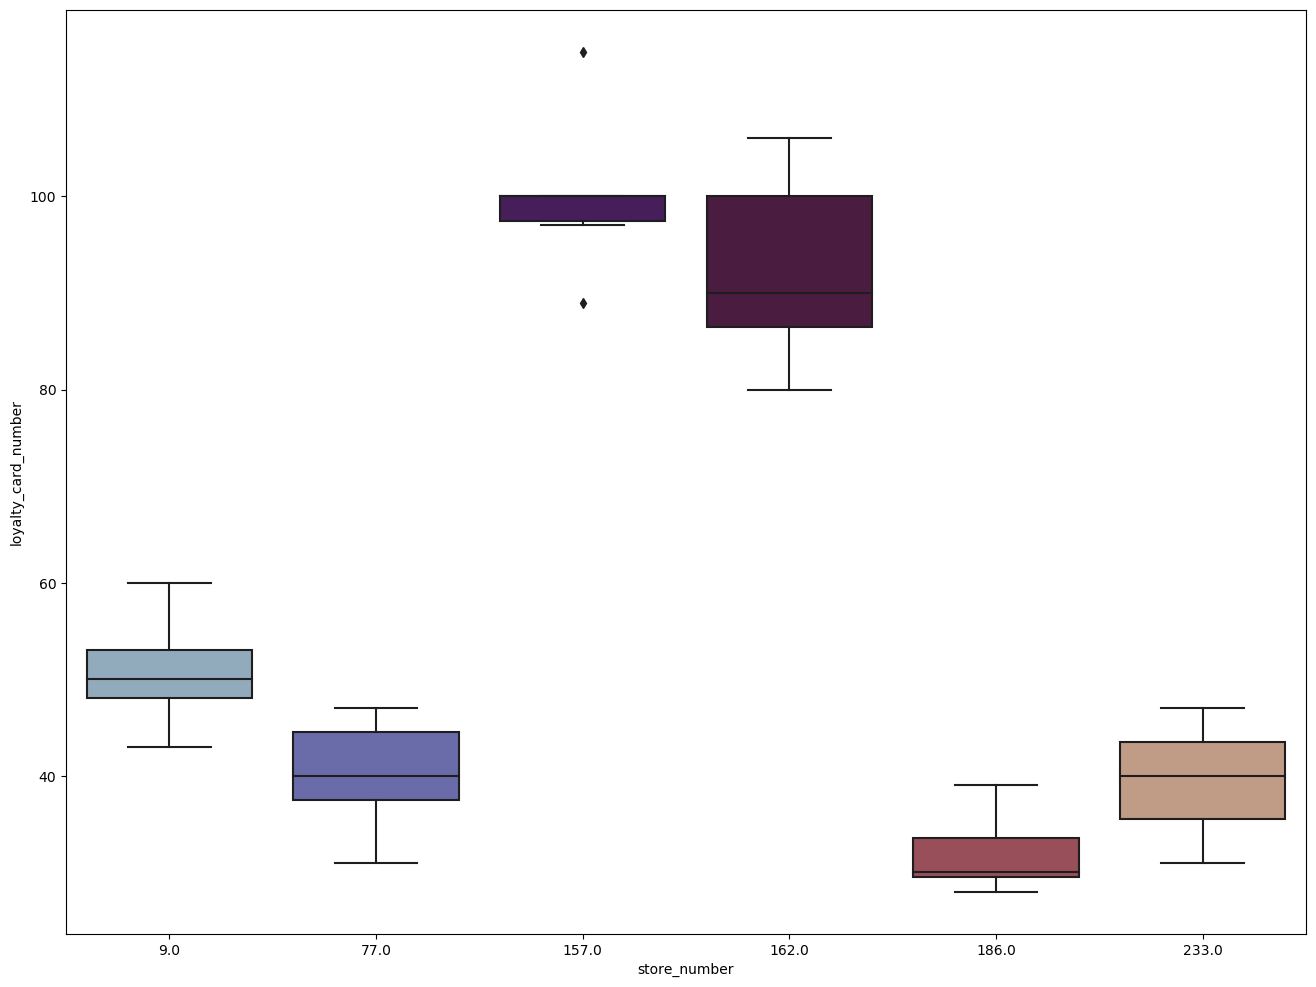

In [67]:
 # store 77
sns.boxplot(data = number_of_customers.\
             query('store_number == 77 or store_number == 9 or store_number == 162\
             or store_number == 157 or store_number == 233 or store_number == 186'),\
             x='store_number', y='loyalty_card_number', palette='twilight')
            


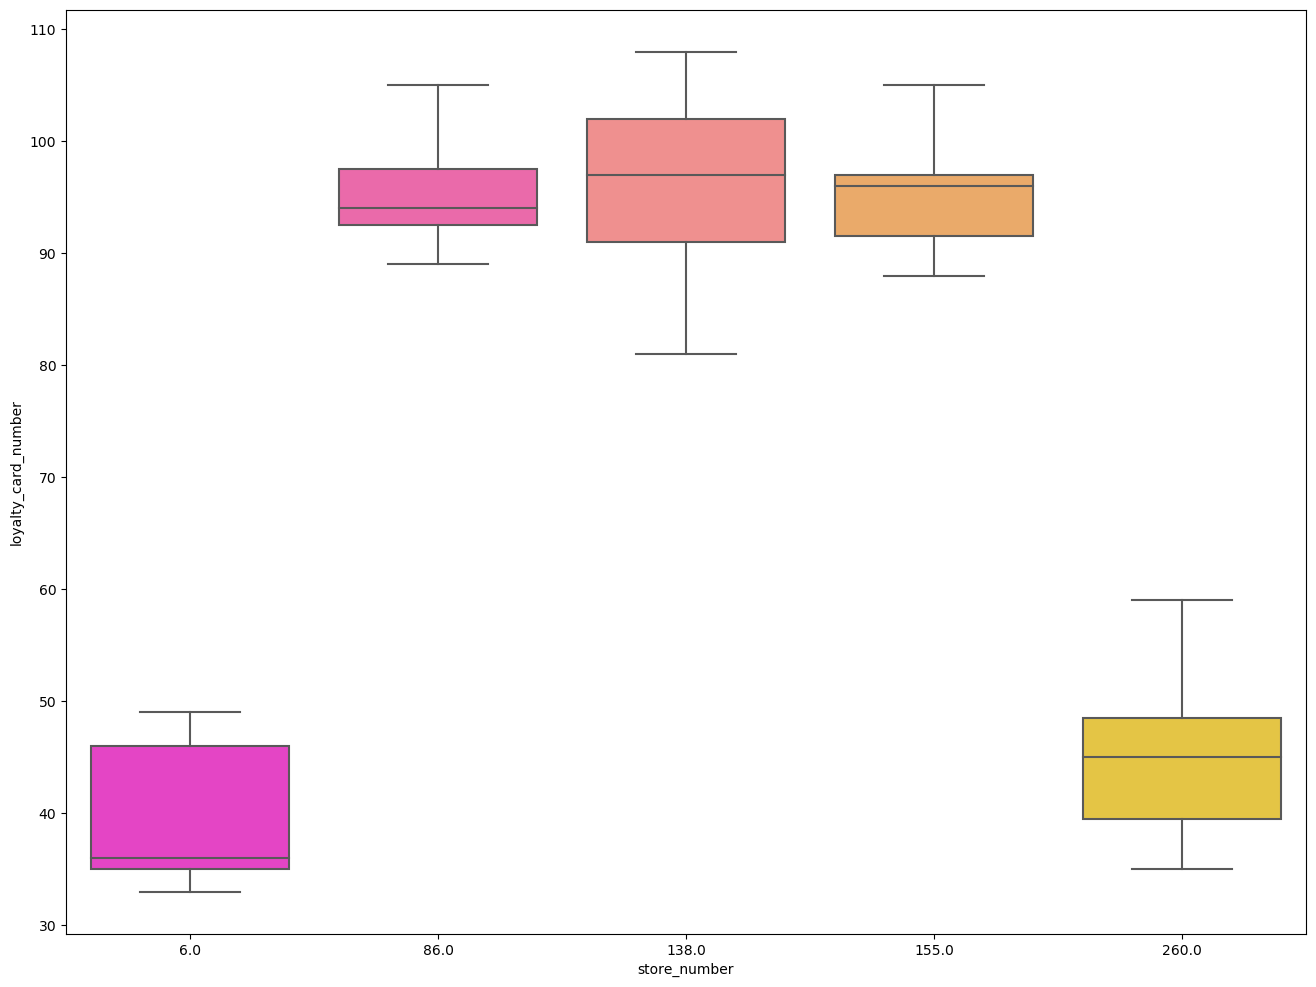

In [68]:
# 86 store
sns.boxplot(data = number_of_customers.\
             query('store_number == 86 or store_number == 6 \
        or store_number == 155 or store_number == 138 or store_number == 260'),\
             x='store_number', y='loyalty_card_number', palette='spring')
            


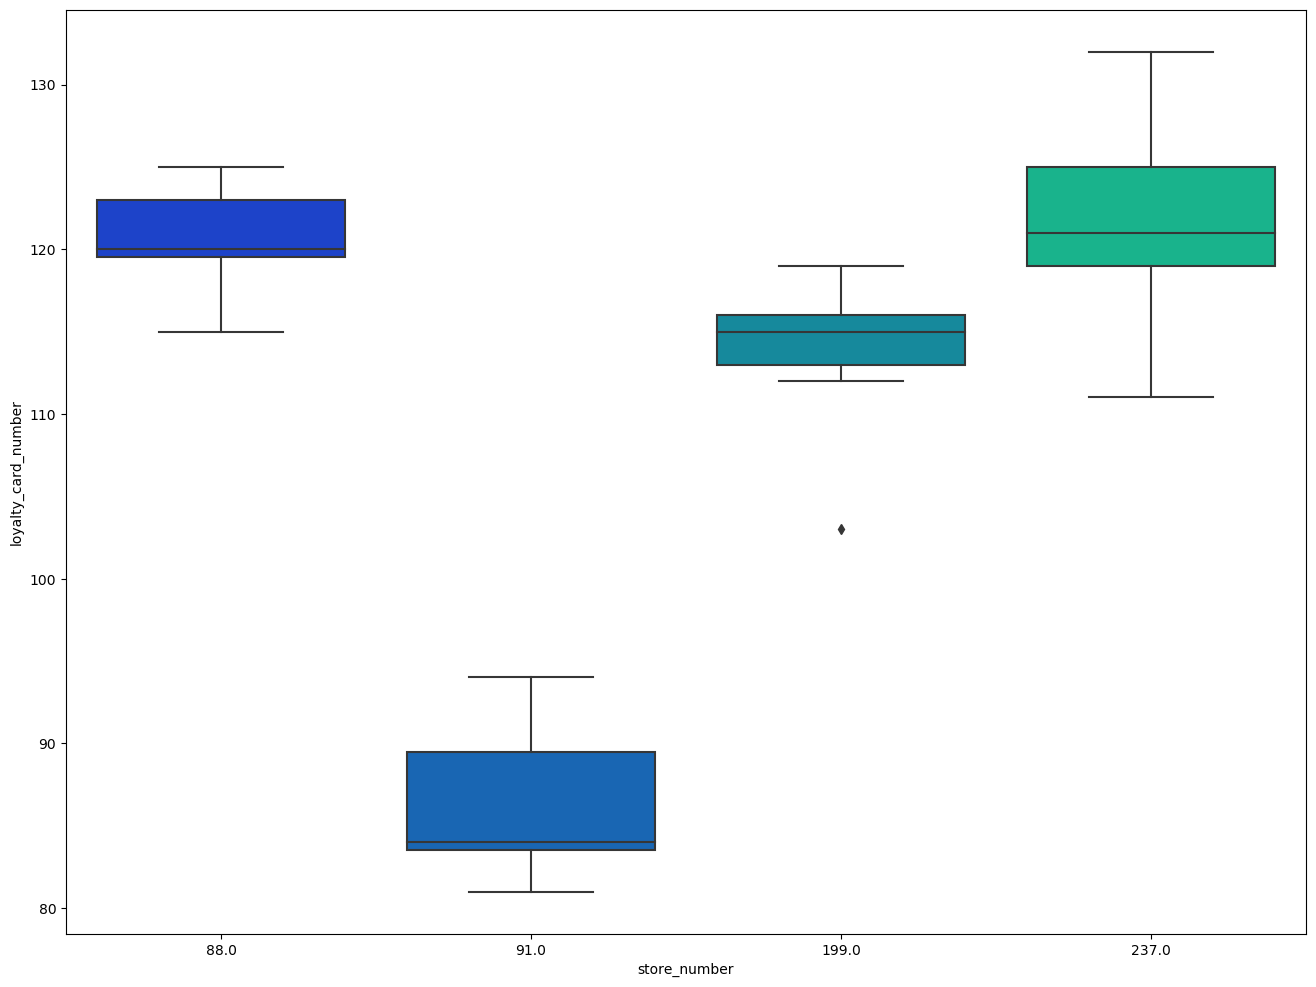

In [69]:
# 88 store
sns.boxplot(data = number_of_customers.\
             query('store_number == 88 or store_number == 91\
             or store_number == 237\
             or store_number == 199'),\
             x='store_number', y='loyalty_card_number', palette='winter')
            

# We found similar to 77 store -  233.0,  similar to 86 store - they are [ 155,  138], and 1 similar to 88 store - 237.

# The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales. 

## Stores 77, 86 and 88 total_sales  and number of customers uplift research

## 77 sales

In [70]:
# 77 store pretrial scaling factor
pretrial_sales_77 = df.query('store_number == 77 and all_dates < "2019-02-01"').total_sales.sum()
pretrial_sales_233 = df.query('store_number == 233 and all_dates < "2019-02-01"').total_sales.sum()
scaling_factor_pretrial_77_233 = pretrial_sales_77/pretrial_sales_233
scaling_factor_pretrial_77_233

1.0397523623330074

In [71]:
# Apply the scaling factor
sales_233_scaled = df.query('store_number == 233')[['total_sales', 'all_dates', 'month']].\
groupby(['all_dates','month'], as_index=False).agg({'total_sales': 'sum'})
sales_233_scaled['total_sales'] = sales_233_scaled.total_sales*scaling_factor_pretrial_77_233

In [72]:
# Calculate the percentage difference between scaled control sales and trial sales
both_233_77 = sales_233_scaled.groupby('month', as_index=False).agg({'total_sales': 'sum'}).merge(df.query('store_number == 77')[['total_sales', 'month']].\
                              groupby(['month'], as_index=False).agg({'total_sales': 'sum'}), \
                              on='month')
both_233_77['percent_diff'] = abs(both_233_77.total_sales_x - both_233_77.total_sales_y)/both_233_77.total_sales_x


#### As our null hypothesis is that the trial period is the same as the pre‐trial period, let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

In [73]:
from scipy.stats import ttest_ind, tstd, t


In [74]:
both_233_77.groupby('month', as_index=False).agg({'percent_diff': 'sum'}).\
                 query('month != "2" and month != "3" and month != "4"').\
                 percent_diff.values

array([0.20396672, 0.17307859, 0.04746491, 0.07519571, 0.16088022,
       0.20391806, 0.04816228, 0.08692962, 0.05608335])

In [75]:
stand_dev = tstd(both_233_77.groupby(['month'], as_index=False).\
                 agg({'percent_diff': 'sum'}).\
                 query('month != "2" and month != "3" and month != "4"').\
                 percent_diff.values)
stand_dev

0.06719734895050541

#### note that there are 8 months in the pre‐trial period hence 8 ‐ 1 = 7 degrees of freedom

In [76]:
deg_free = 7

In [77]:
t_values_both_233_77 = both_233_77.groupby('month', as_index=False).agg({'percent_diff': 'sum'})
t_values_both_233_77['t_values'] = t_values_both_233_77.percent_diff/stand_dev
t_values_both_233_77

,month,percent_diff,t_values
0,1,0.203967,3.035339
1,10,0.173079,2.575676
2,11,0.047465,0.706351
3,12,0.075196,1.119028
4,2,0.077889,1.159102
5,3,0.358510,5.335179
6,4,0.721444,10.736193
7,5,0.160880,2.394145
8,6,0.203918,3.034615
9,7,0.048162,0.716729


In [78]:
deg_free = 7
t.interval(confidence=0.95, df=deg_free, loc=0, scale=1)


(-2.3646242510102993, 2.3646242510102993)

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store

In [79]:
for_plot_233_77 = sales_233_scaled.\
                    groupby(['month'], as_index=False).\
                    agg({'total_sales': 'sum'})
for_plot_233_77['95ql'] = for_plot_233_77.total_sales *(1+stand_dev*2)
for_plot_233_77['5ql'] = for_plot_233_77.total_sales*(1-stand_dev*2)

for_plot_233_77['77'] = df.query('store_number == 77').\
groupby(['month'], as_index=False).\
agg({'total_sales': 'sum'}).total_sales
for_plot_233_77 = for_plot_233_77.reindex(index = [9,10,11,1,2,1,3,0,4,5,6,7,8])

### Lineplot for a whole period to show difference between control - 233 and trial - 77 stores

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

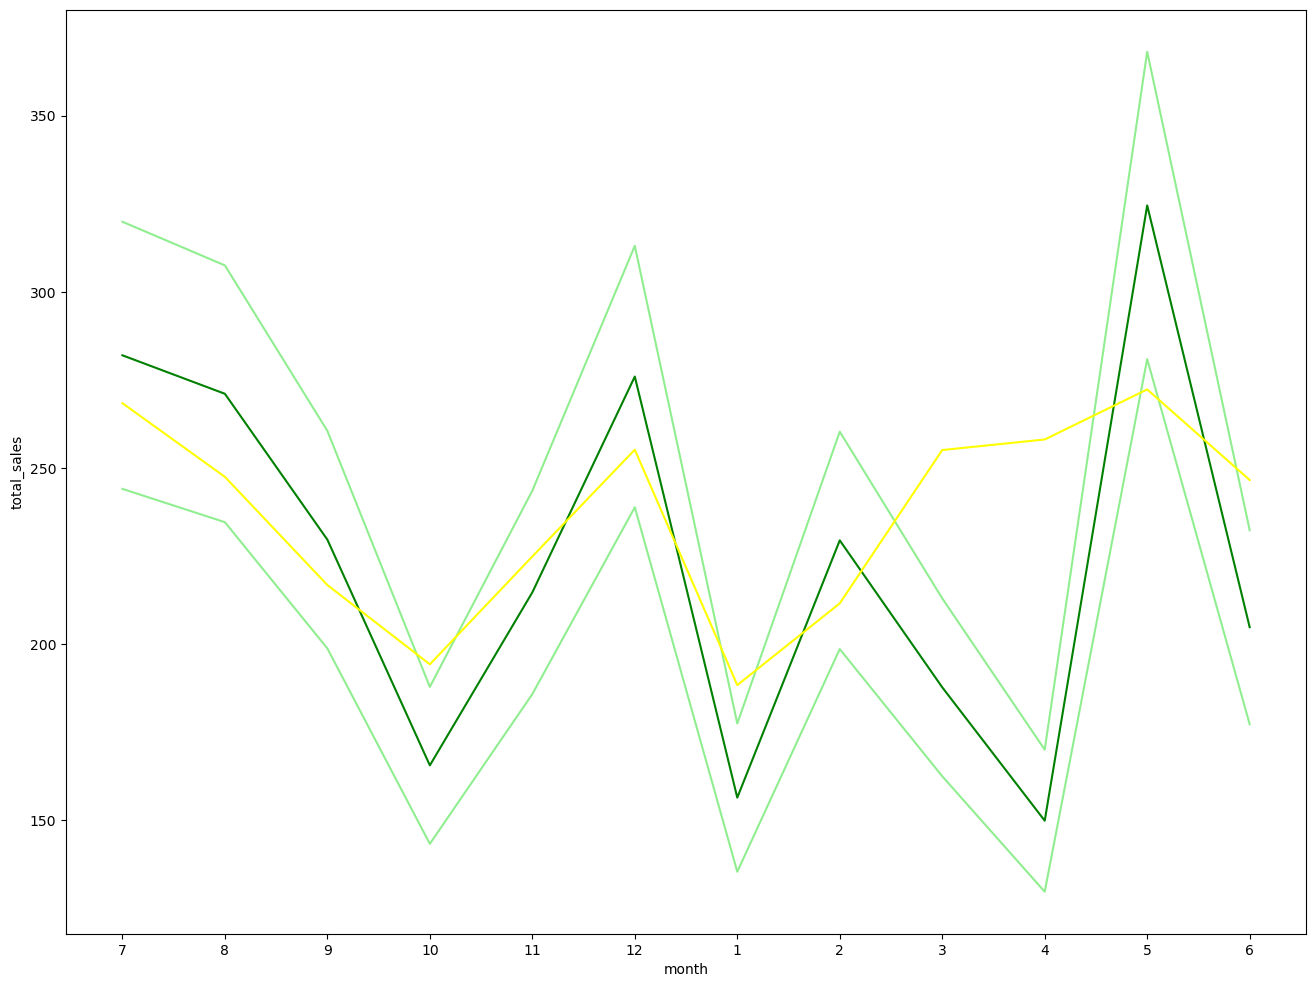

In [80]:
sns.lineplot(data=for_plot_233_77, x='month', y='total_sales', color='green')
sns.lineplot(data=for_plot_233_77, x='month', y='95ql', color='lightgreen')
sns.lineplot(data=for_plot_233_77, x='month', y='5ql', color='lightgreen')
sns.lineplot(data=for_plot_233_77, x='month', y='77', color='yellow')
plt.savefig('sales-233-77.png')

## The results show that the trial figures in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months

## 77 customers

In [81]:
# 77 store pretrial scaling factor
pretrial_cust_77 = df.query('store_number == 77 and all_dates < "2019-02-01"').loyalty_card_number.nunique()
pretrial_cust_233 = df.query('store_number == 233 and all_dates < "2019-02-01"').loyalty_card_number.nunique()
scaling_factor_pretrial_cust_77_233 = pretrial_cust_77/pretrial_cust_233
scaling_factor_pretrial_cust_77_233

1.0

In [82]:
# Apply the scaling factor
sales_cust_233_scaled = df.query('store_number == 233')[['loyalty_card_number', 'month']].\
                        groupby(['month'], as_index=False).\
                        loyalty_card_number.nunique()

sales_cust_233_scaled['scaled_number'] = sales_cust_233_scaled.\
                       loyalty_card_number*scaling_factor_pretrial_cust_77_233


In [83]:
# Calculate the percentage difference between scaled control sales and trial sales
both_cust_233_77 = sales_cust_233_scaled.merge(df.query('store_number == 77')[['loyalty_card_number', 'month']].\
                        groupby(['month'], as_index=False).\
                        loyalty_card_number.nunique(), \
                        on='month')
both_cust_233_77['percent_diff'] =\
                 abs(both_cust_233_77.loyalty_card_number_x - both_cust_233_77.loyalty_card_number_y)/both_cust_233_77.loyalty_card_number_x


In [84]:
both_cust_233_77.groupby('month', as_index=False).agg({'percent_diff': 'sum'}).\
                 query('month != "2" and month != "3" and month != "4"').\
                 percent_diff.values

array([0.        , 0.125     , 0.        , 0.        , 0.01851852,
       0.11764706, 0.        , 0.04545455, 0.        ])

In [85]:
stand_dev = tstd(both_cust_233_77.groupby(['month'], as_index=False).\
                 agg({'percent_diff': 'sum'}).\
                 query('month != "2" and month != "3" and month != "4"').\
                 percent_diff.values)
stand_dev

0.051755036714105494

In [86]:
t_values_both_cust_233_77 = both_cust_233_77.groupby('month', as_index=False).agg({'percent_diff': 'sum'})
t_values_both_cust_233_77['t_values'] = t_values_both_cust_233_77.percent_diff/stand_dev
t_values_both_cust_233_77

,month,percent_diff,t_values
0,1,0.000000,0.000000
1,10,0.125000,2.415224
2,11,0.000000,0.000000
3,12,0.000000,0.000000
4,2,0.047619,0.920085
5,3,0.314286,6.072563
6,4,0.740741,14.312438
7,5,0.018519,0.357811
8,6,0.117647,2.273152
9,7,0.000000,0.000000


In [87]:
deg_free = 7
t.interval(confidence=0.95, df=deg_free, loc=0, scale=1)

(-2.3646242510102993, 2.3646242510102993)

In [88]:
for_plot_cust_233_77 = sales_cust_233_scaled
for_plot_cust_233_77['95ql'] = for_plot_cust_233_77.scaled_number *(1+stand_dev*2)
for_plot_cust_233_77['5ql'] = for_plot_cust_233_77.scaled_number*(1-stand_dev*2)

for_plot_cust_233_77['77'] = df.query('store_number == 77').\
                             groupby(['month'], as_index=False).loyalty_card_number.nunique().loyalty_card_number
for_plot_cust_233_77 = for_plot_cust_233_77.reindex(index = [9,10,11,1,2,1,3,0,4,5,6,7,8])

### Lineplot for a whole period to show difference between control - 233 and trial - 77 stores

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

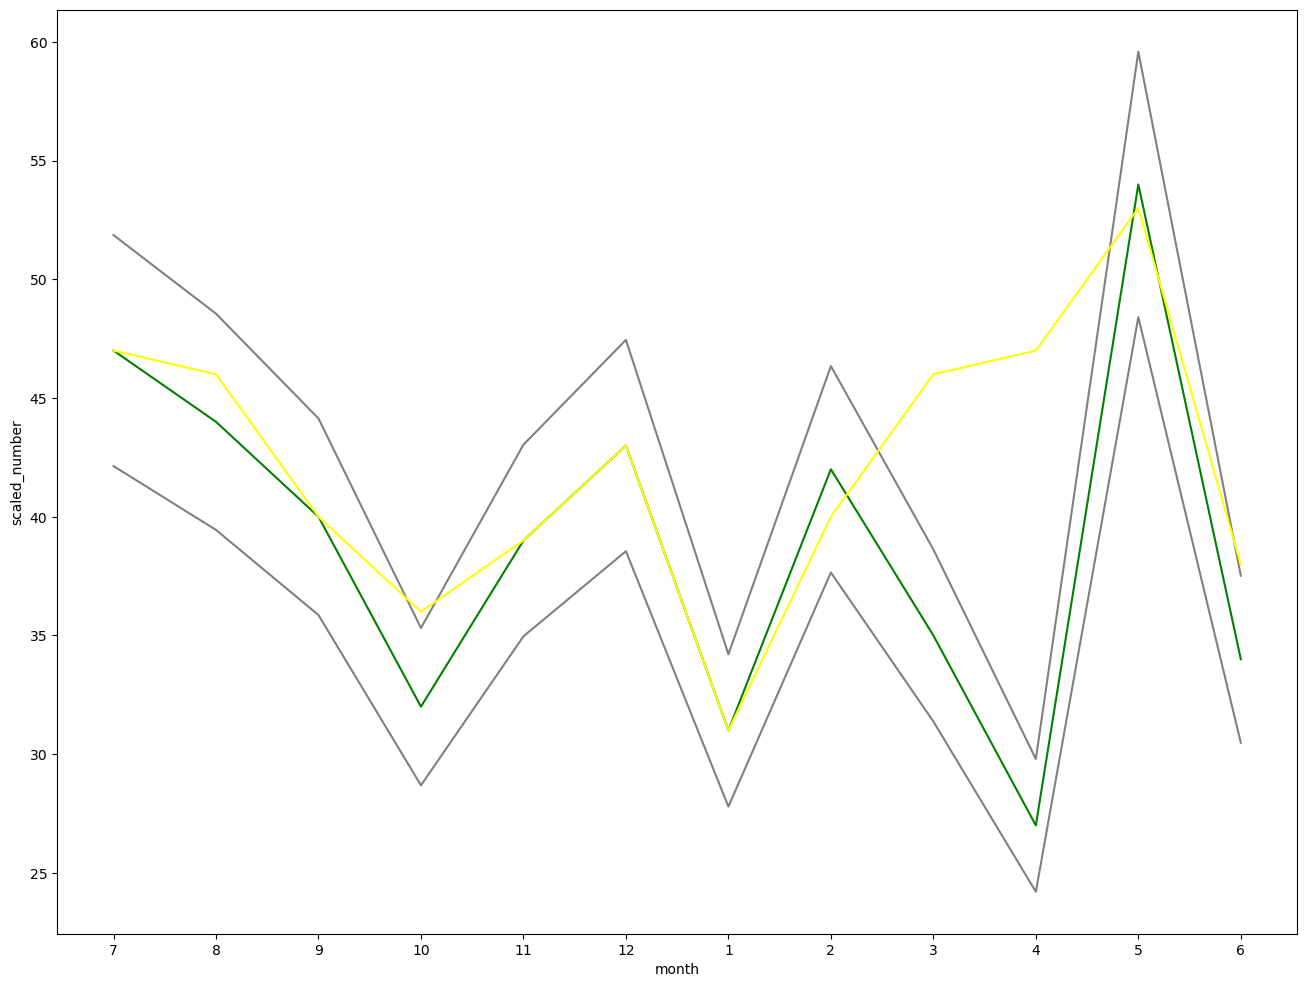

In [89]:
sns.lineplot(data=for_plot_cust_233_77, x='month', y='scaled_number', color='green')
sns.lineplot(data=for_plot_cust_233_77, x='month', y='95ql', color='grey')
sns.lineplot(data=for_plot_cust_233_77, x='month', y='5ql', color='grey')
sns.lineplot(data=for_plot_cust_233_77, x='month', y='77', color='yellow')
plt.savefig('customers-233-77.png')

## We can see that increase of customers was significant too

## 86 sales

In [90]:
# 86 store pretrial scaling factor
pretrial_sales_86 = df.query('store_number == 86 and all_dates < "2019-02-01"').total_sales.sum()
pretrial_sales_155 = df.query('store_number == 155 and all_dates < "2019-02-01"').total_sales.sum()
scaling_factor_pretrial_86_155 = pretrial_sales_86/pretrial_sales_155
scaling_factor_pretrial_86_155

0.9720493769183033

In [91]:
# Apply the scaling factor
sales_155_scaled = df.query('store_number == 155')[['total_sales', 'all_dates', 'month']].\
groupby(['all_dates','month'], as_index=False).agg({'total_sales': 'sum'})
sales_155_scaled['total_sales'] = sales_155_scaled.total_sales*scaling_factor_pretrial_86_155

In [92]:
# Calculate the percentage difference between scaled control sales and trial sales
both_155_86 = sales_155_scaled.groupby('month', as_index=False).\
                                agg({'total_sales': 'sum'}).\
                                merge(df.query('store_number == 86')[['total_sales', 'month']].\
                              groupby(['month'], as_index=False).agg({'total_sales': 'sum'}), \
                              on='month')
both_155_86['percent_diff'] = abs(both_155_86.total_sales_x - both_155_86.total_sales_y)/both_155_86.total_sales_x


In [93]:
stand_dev = tstd(both_155_86.groupby(['month'], as_index=False).\
                 agg({'percent_diff': 'sum'}).\
                 query('month != "2" and month != "3" and month != "4"').\
                 percent_diff.values)
stand_dev

0.0191205988044067

In [94]:
t_values_both_155_86 = both_155_86.groupby('month', as_index=False).agg({'percent_diff': 'sum'})
t_values_both_155_86['t_values'] = t_values_both_155_86.percent_diff/stand_dev
t_values_both_155_86

,month,percent_diff,t_values
0,1,0.013155,0.688009
1,10,0.011646,0.609078
2,11,0.048713,2.547692
3,12,0.044704,2.338002
4,2,0.055356,2.895091
5,3,0.268037,14.018230
6,4,0.033381,1.745835
7,5,0.014565,0.761733
8,6,0.035786,1.871582
9,7,0.027904,1.459353


In [95]:
deg_free = 7
t.interval(confidence=0.95, df=deg_free, loc=0, scale=1)


(-2.3646242510102993, 2.3646242510102993)

In [96]:
for_plot_155_86 = sales_155_scaled.\
                    groupby(['month'], as_index=False).\
                    agg({'total_sales': 'sum'})
for_plot_155_86['95ql'] = for_plot_155_86.total_sales *(1+stand_dev*2)
for_plot_155_86['5ql'] = for_plot_155_86.total_sales*(1-stand_dev*2)

for_plot_155_86['86'] = df.query('store_number == 86').\
groupby(['month'], as_index=False).\
agg({'total_sales': 'sum'}).total_sales
for_plot_155_86 = for_plot_155_86.reindex(index = [9,10,11,1,2,1,3,0,4,5,6,7,8])

### Lineplot for a whole period to show difference between control - 155 and trial - 86 stores

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

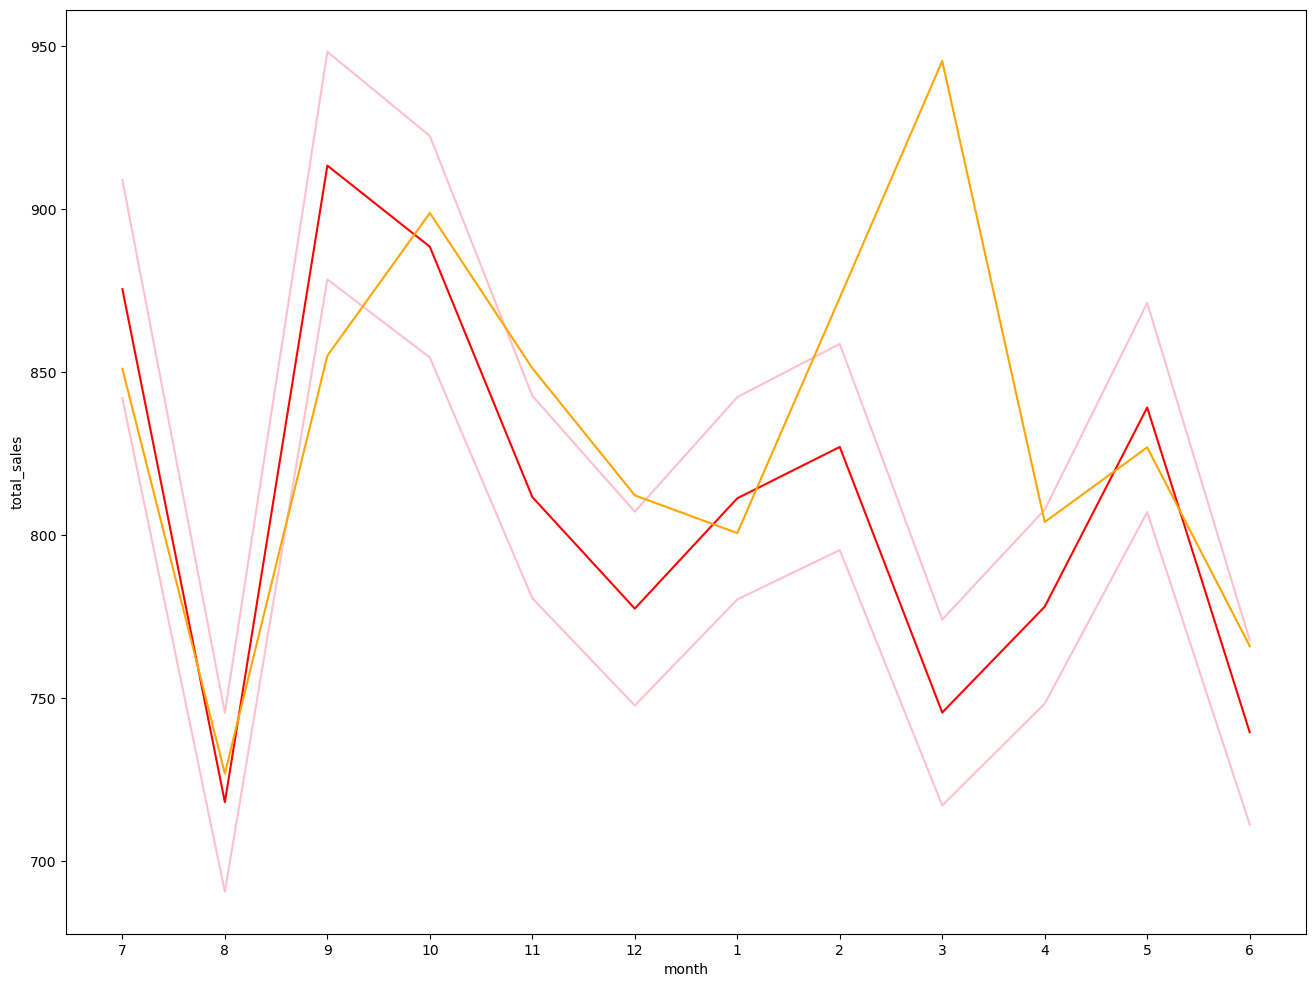

In [97]:
sns.lineplot(data=for_plot_155_86, x='month', y='total_sales', color='red')
sns.lineplot(data=for_plot_155_86, x='month', y='95ql', color='pink')
sns.lineplot(data=for_plot_155_86, x='month', y='5ql', color='pink')
sns.lineplot(data=for_plot_155_86, x='month', y='86', color='orange')
plt.savefig('sales-155-86.png')

## The results show that the trial figures in store 86 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in one of the three trial months.

## 86 customers

In [98]:
# 86 store pretrial scaling factor
pretrial_cust_86 = df.query('store_number == 86 and all_dates < "2019-02-01"').loyalty_card_number.nunique()
pretrial_cust_155 = df.query('store_number == 155 and all_dates < "2019-02-01"').loyalty_card_number.nunique()
scaling_factor_pretrial_cust_86_155 = pretrial_cust_86/pretrial_cust_155
scaling_factor_pretrial_cust_86_155

1.037344398340249

In [99]:
# Apply the scaling factor
sales_cust_155_scaled = df.query('store_number == 155')[['loyalty_card_number', 'month']].\
                        groupby(['month'], as_index=False).\
                        loyalty_card_number.nunique()

sales_cust_155_scaled['scaled_number'] = sales_cust_155_scaled.\
                       loyalty_card_number*scaling_factor_pretrial_cust_86_155


In [100]:
# Calculate the percentage difference between scaled control sales and trial sales
both_cust_155_86 = sales_cust_155_scaled.merge(df.query('store_number == 86')[['loyalty_card_number', 'month']].\
                        groupby(['month'], as_index=False).\
                        loyalty_card_number.nunique(), \
                        on='month')
both_cust_155_86['percent_diff'] =\
                 abs(both_cust_155_86.loyalty_card_number_x - both_cust_155_86.loyalty_card_number_y)/both_cust_155_86.loyalty_card_number_x


In [101]:
both_cust_155_86.groupby('month', as_index=False).agg({'percent_diff': 'sum'}).\
                 query('month != "2" and month != "3" and month != "4"').\
                 percent_diff.values

array([0.0326087 , 0.        , 0.01041667, 0.02197802, 0.01980198,
       0.05747126, 0.04081633, 0.04545455, 0.04166667])

In [102]:
stand_dev = tstd(both_cust_155_86.groupby(['month'], as_index=False).\
                 agg({'percent_diff': 'sum'}).\
                 query('month != "2" and month != "3" and month != "4"').\
                 percent_diff.values)
stand_dev

0.018389114484539407

In [103]:
t_values_both_cust_155_86 = both_cust_155_86.groupby('month', as_index=False).agg({'percent_diff': 'sum'})
t_values_both_cust_155_86['t_values'] = t_values_both_cust_155_86.percent_diff/stand_dev
t_values_both_cust_155_86

,month,percent_diff,t_values
0,1,0.032609,1.773261
1,10,0.000000,0.000000
2,11,0.010417,0.566458
3,12,0.021978,1.195165
4,2,0.141304,7.684130
5,3,0.186813,10.158901
6,4,0.064516,3.508387
7,5,0.019802,1.076832
8,6,0.057471,3.125287
9,7,0.040816,2.219592


In [104]:
deg_free = 7
t.interval(confidence=0.95, df=deg_free, loc=0, scale=1)

(-2.3646242510102993, 2.3646242510102993)

In [105]:
for_plot_cust_155_86 = sales_cust_155_scaled
for_plot_cust_155_86['95ql'] = for_plot_cust_155_86.scaled_number *(1+stand_dev*2)
for_plot_cust_155_86['5ql'] = for_plot_cust_155_86.scaled_number*(1-stand_dev*2)

for_plot_cust_155_86['86'] = df.query('store_number == 86').\
                             groupby(['month'], as_index=False).loyalty_card_number.nunique().loyalty_card_number
for_plot_cust_155_86 = for_plot_cust_155_86.reindex(index = [9,10,11,1,2,1,3,0,4,5,6,7,8])

### Lineplot for a whole period to show difference between control - 155 and trial - 86 stores

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

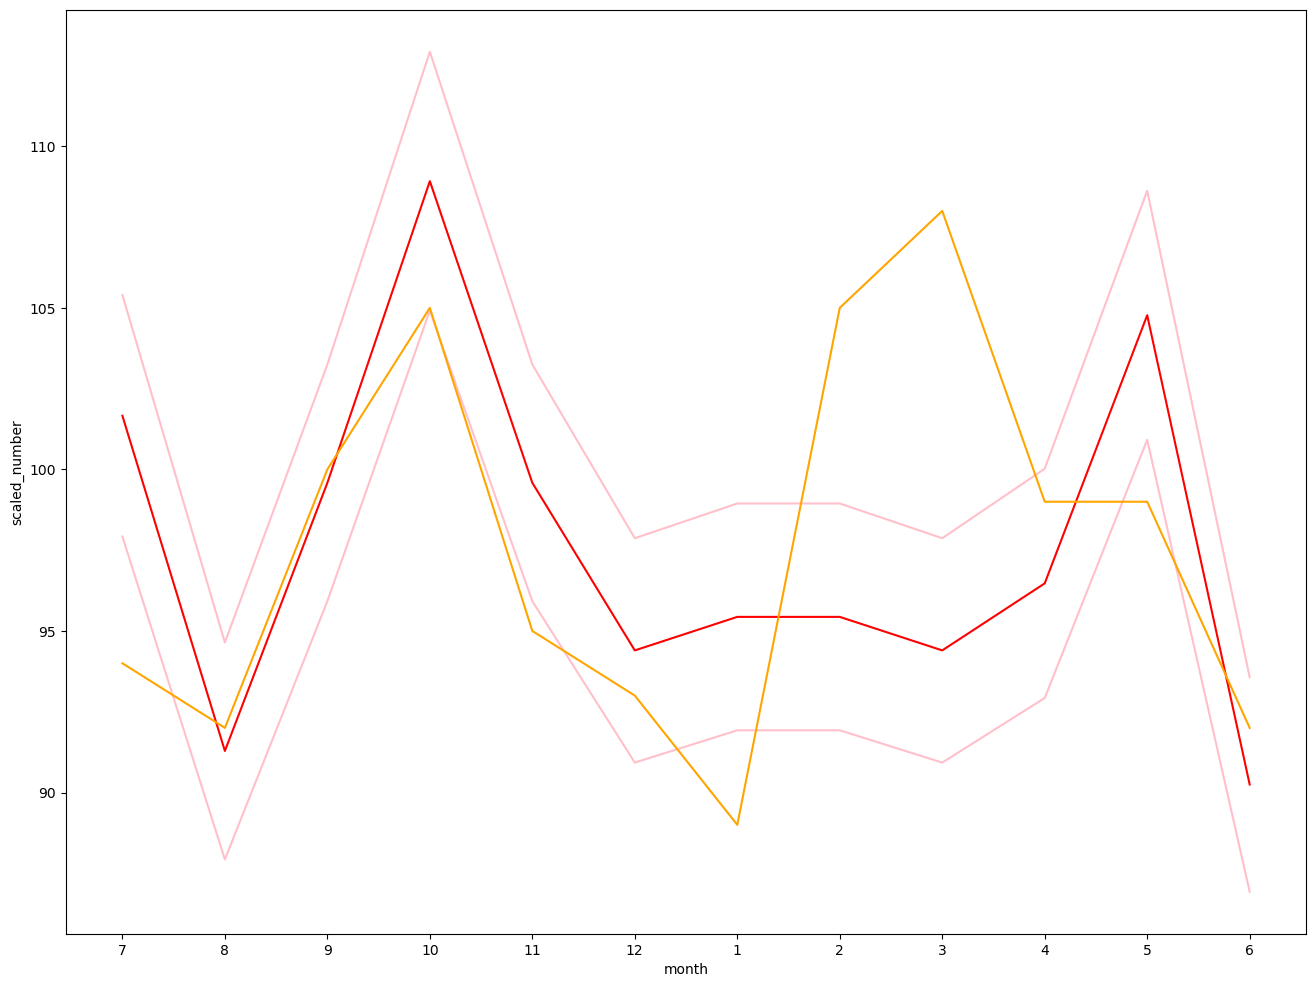

In [106]:
sns.lineplot(data=for_plot_cust_155_86, x='month', y='scaled_number', color='red')
sns.lineplot(data=for_plot_cust_155_86, x='month', y='95ql', color='pink')
sns.lineplot(data=for_plot_cust_155_86, x='month', y='5ql', color='pink')
sns.lineplot(data=for_plot_cust_155_86, x='month', y='86', color='orange')
plt.savefig('customers-155-86.png')

## It looks like the number of customers is significantly higher in all of the three months.

## 88 sales

In [107]:
# 88 store pretrial scaling factor
pretrial_sales_88 = df.query('store_number == 88 and all_dates < "2019-02-01"').total_sales.sum()
pretrial_sales_237 = df.query('store_number == 237 and all_dates < "2019-02-01"').total_sales.sum()
scaling_factor_pretrial_88_237 = pretrial_sales_88/pretrial_sales_237
scaling_factor_pretrial_88_237

0.9867752464919073

In [108]:
# Apply the scaling factor
sales_237_scaled = df.query('store_number == 237')[['total_sales', 'all_dates', 'month']].\
groupby(['all_dates','month'], as_index=False).agg({'total_sales': 'sum'})
sales_237_scaled['total_sales'] = sales_237_scaled.total_sales*scaling_factor_pretrial_88_237

In [109]:
# Calculate the percentage difference between scaled control sales and trial sales
both_237_88 = sales_237_scaled.groupby('month', as_index=False).\
                                agg({'total_sales': 'sum'}).\
                                merge(df.query('store_number == 88')[['total_sales', 'month']].\
                              groupby(['month'], as_index=False).agg({'total_sales': 'sum'}), \
                              on='month')
both_237_88['percent_diff'] = abs(both_237_88.total_sales_x - both_237_88.total_sales_y)/both_237_88.total_sales_x


In [110]:
stand_dev = tstd(both_237_88.groupby(['month'], as_index=False).\
                 agg({'percent_diff': 'sum'}).\
                 query('month != "2" and month != "3" and month != "4"').\
                 percent_diff.values)
stand_dev

0.04957564998781151

In [111]:
t_values_both_237_88 = both_237_88.groupby('month', as_index=False).agg({'percent_diff': 'sum'})
t_values_both_237_88['t_values'] = t_values_both_237_88.percent_diff/stand_dev
t_values_both_237_88

,month,percent_diff,t_values
0,1,0.101985,2.057162
1,10,0.006361,0.128300
2,11,0.009860,0.198882
3,12,0.004167,0.084047
4,2,0.033932,0.684458
5,3,0.307543,6.203515
6,4,0.150267,3.031074
7,5,0.103026,2.078156
8,6,0.110187,2.222595
9,7,0.123209,2.485264


In [112]:
deg_free = 7
t.interval(confidence=0.95, df=deg_free, loc=0, scale=1)

(-2.3646242510102993, 2.3646242510102993)

In [113]:
for_plot_237_88 = sales_237_scaled.\
                    groupby(['month'], as_index=False).\
                    agg({'total_sales': 'sum'})
for_plot_237_88['95ql'] = for_plot_237_88.total_sales *(1+stand_dev*2)
for_plot_237_88['5ql'] = for_plot_237_88.total_sales*(1-stand_dev*2)

for_plot_237_88['88'] = df.query('store_number == 88').\
groupby(['month'], as_index=False).\
agg({'total_sales': 'sum'}).total_sales
for_plot_237_88 = for_plot_237_88.reindex(index = [9,10,11,1,2,1,3,0,4,5,6,7,8])

### Lineplot for a whole period to show difference between control - 237 and trial - 88 stores

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

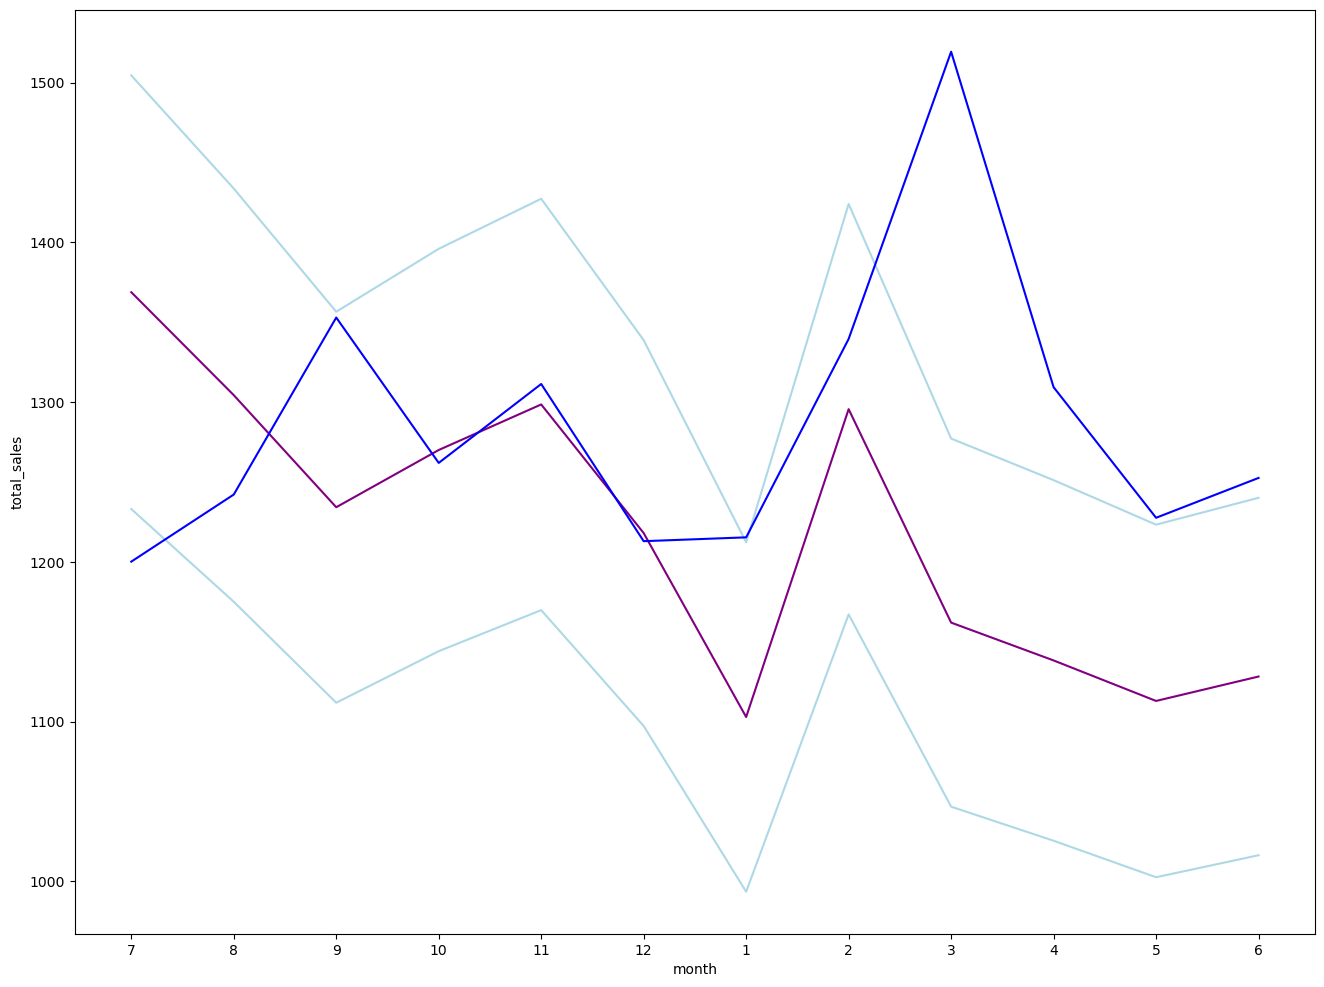

In [114]:
sns.lineplot(data=for_plot_237_88, x='month', y='total_sales', color='purple')
sns.lineplot(data=for_plot_237_88, x='month', y='95ql', color='lightblue')
sns.lineplot(data=for_plot_237_88, x='month', y='5ql', color='lightblue')
sns.lineplot(data=for_plot_237_88, x='month', y='88', color='blue')
plt.savefig('sales-237-88.png')

## The results show that the trial in store 88 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.

## 88 customers

In [115]:
# 88 store pretrial scaling factor
pretrial_cust_88 = df.query('store_number == 88 and all_dates < "2019-02-01"').loyalty_card_number.nunique()
pretrial_cust_237 = df.query('store_number == 237 and all_dates < "2019-02-01"').loyalty_card_number.nunique()
scaling_factor_pretrial_cust_88_237 = pretrial_cust_88/pretrial_cust_237
scaling_factor_pretrial_cust_88_237

1.0391061452513966

In [116]:
# Apply the scaling factor
sales_cust_237_scaled = df.query('store_number == 237')[['loyalty_card_number', 'month']].\
                        groupby(['month'], as_index=False).\
                        loyalty_card_number.nunique()

sales_cust_237_scaled['scaled_number'] = sales_cust_237_scaled.\
                       loyalty_card_number*scaling_factor_pretrial_cust_88_237


In [117]:
# Calculate the percentage difference between scaled control sales and trial sales
both_cust_237_88 = sales_cust_237_scaled.merge(df.query('store_number == 88')[['loyalty_card_number', 'month']].\
                        groupby(['month'], as_index=False).\
                        loyalty_card_number.nunique(), \
                        on='month')
both_cust_237_88['percent_diff'] =\
                 abs(both_cust_237_88.loyalty_card_number_x - both_cust_237_88.loyalty_card_number_y)/both_cust_237_88.loyalty_card_number_x


In [118]:
both_cust_237_88.groupby('month', as_index=False).agg({'percent_diff': 'sum'}).\
                 query('month != "2" and month != "3" and month != "4"').\
                 percent_diff.values

array([0.03603604, 0.00847458, 0.016     , 0.00826446, 0.        ,
       0.04237288, 0.016     , 0.0530303 , 0.        ])

In [119]:
stand_dev = tstd(both_cust_237_88.groupby(['month'], as_index=False).\
                 agg({'percent_diff': 'sum'}).\
                 query('month != "2" and month != "3" and month != "4"').\
                 percent_diff.values)
stand_dev

0.019206951491390737

In [120]:
t_values_both_cust_237_88 = both_cust_237_88.groupby('month', as_index=False).agg({'percent_diff': 'sum'})
t_values_both_cust_237_88['t_values'] = t_values_both_cust_237_88.percent_diff/stand_dev
t_values_both_cust_237_88

,month,percent_diff,t_values
0,1,0.036036,1.876198
1,10,0.008475,0.441224
2,11,0.016000,0.833032
3,12,0.008264,0.430285
4,2,0.025210,1.312550
5,3,0.155172,8.078972
6,4,0.017241,0.897664
7,5,0.000000,0.000000
8,6,0.042373,2.206122
9,7,0.016000,0.833032


In [121]:
deg_free = 7
t.interval(confidence=0.95, df=deg_free, loc=0, scale=1)

(-2.3646242510102993, 2.3646242510102993)

In [122]:
for_plot_cust_237_88 = sales_cust_237_scaled
for_plot_cust_237_88['95ql'] = for_plot_cust_237_88.scaled_number *(1+stand_dev*2)
for_plot_cust_237_88['5ql'] = for_plot_cust_237_88.scaled_number*(1-stand_dev*2)

for_plot_cust_237_88['88'] = df.query('store_number == 88').\
                             groupby(['month'], as_index=False).loyalty_card_number.nunique().loyalty_card_number
for_plot_cust_237_88 = for_plot_cust_237_88.reindex(index = [9,10,11,1,2,1,3,0,4,5,6,7,8])

### Lineplot for a whole period to show difference between control - 237 and trial - 88 stores

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

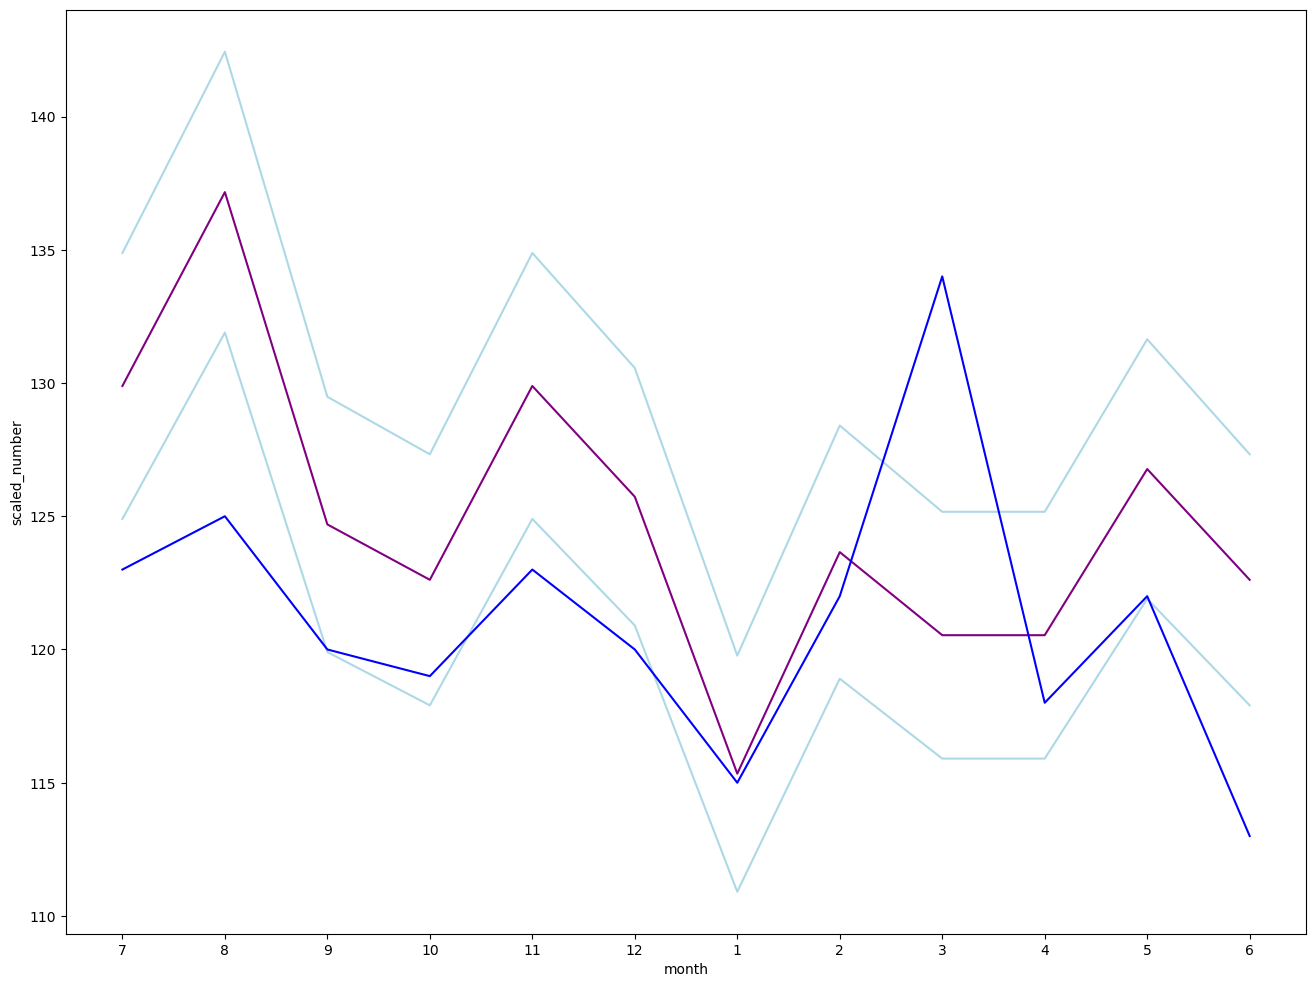

In [123]:
sns.lineplot(data=for_plot_cust_237_88, x='month', y='scaled_number', color='purple')
sns.lineplot(data=for_plot_cust_237_88, x='month', y='95ql', color='lightblue')
sns.lineplot(data=for_plot_cust_237_88, x='month', y='5ql', color='lightblue')
sns.lineplot(data=for_plot_cust_237_88, x='month', y='88', color='blue')
plt.savefig('customers-237-88.png')

###### Conclusion
We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively. The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86. We can check with the client if the implementation of the trial was different in trial store 86, but overall, the trial shows a significant increase in sales. Now that we have finished our analysis, we can prepare our presentation to the Category Manager.

In [124]:
#!jupyter nbconvert --to webpdf --allow-chromium-download quantium_task2.ipynb